<span style="font-size: 24px; font-weight: bold">第十章·人工神经网络介绍</span>

目标：
1. ANN架构；
2. MLP；
3. MNIST数字分类

为什么ANN：
1. 有了大量的数据用于训练；
2. 计算能力的提高；
3. 改进了训练算法；
4. 理论局限性是良性的；
5. ANN进入资金和进步的良性循环。

# 感知器

神经元：线性阈值单元。

输入和输出是数字，每个输入连接都与权重相连。

$h_w(X) = \text{step}(w^T \cdot X)$

阶跃函数：

$\text{heaviside}(z) = \begin{cases} 0 & if\ z < 0 \\ 1 & if\ z ≥ 0\end{cases}$ $\text{sgn}(z) = \begin{cases} -1 & if\ z < 0 \\ 0 & if\ z = 0 \\ +1 & if\ z > 0 \end{cases}$

感知器训练：不加强导致错误输出的连接

$$w_{i, j}^{\text(next step)} = w_{i, j} + \eta(\hat{y_j} - y_j) * x_i$$
- $w_{i, j}$ 是第 $i$ 输入神经元与第 $j$ 个输入神经元之间的连接权重
- $x_i$ 是当前训练实例与输入值
- $\hat{y}_j$ 是当前训练实例的第 $j$ 个输出神经元的输出
- $y_j$ 是当前训练实例的第 $j$ 个输出神经元的**目标**输出
- $\eta$ 是学习率

决策边界是线性的。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

%matplotlib inline

In [2]:
def plot_decision_bundary(estimator, X, y, title=None, num=100):
    """画出决策边界"""
    X1_lin = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, num=num)
    X2_lin = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, num=num)
    X11, X22 = np.meshgrid(X1_lin, X2_lin)
    Z = estimator.predict(np.c_[X11.ravel(), X22.ravel()]).reshape(X11.shape)
    plt.contourf(X1_lin, X2_lin, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    if title:
        plt.title(title)

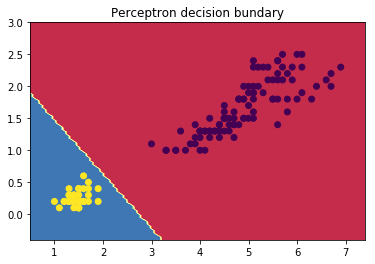

In [4]:
iris = load_iris()
X, y = iris.data[:, (2, 3)], (iris.target == 0).astype(np.int)
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)
plot_decision_bundary(per_clf, X, y, title="Perceptron decision bundary")

感知机算法类似于随机梯度下降。

sklearn的感知器类相当于 `SGDClassifier(loss="perceptron", learning_rate="constant", eta0=1, penalty=None)`。

感知器不输出类概率。

感知器的一些局限性可以通过堆叠多个感知器来消除。（多层感知器MLP）。

MLP可以解决异或问题。

![mlp-异或](../images/10-mlp-xor.png)

# 多层感知器和反向传播

人工神经网络有两个或多个隐含层时，称为深度神经网络(DNN)

训练：对于每个训练实例，反向传播算法首先进行预测(前向)，测量误差，然后反向遍历每个层来测量每个连接(反向传递)的误差贡献，最后稍微调整连接器权值以减少误差(梯度下降步长)。

用 Logistic 函数代替了阶跃函数：
$$\sigma(z) = \frac{1}{1+exp(-z)}$$

另外流行的激活函数：
- 双曲正切函数： $\text{tanh}(z)=2\sigma(2z)-1$，S形、连续、可微。输出范围(-1, 1)，有助于加快收敛速度。
- Relu函数：$\text{RELU}(z)=\text{max}(0, z)$。连续的，在 `z=0` 时不可微。实践中，工作的很好。快速计算的优点。没有最大输出值有助于减少梯度下降期间的一些问题。

![常用激活函数的图形](../images/10-activation-func.png)

多分类：softmax，二分类：sigmoid。

生物神经元似乎是用 sigmoid 激活函数活动的，Relu激活函数通常在 ANN 工作得更好。

# 用TensorFlow高级API训练MLP

In [10]:
import tensorflow as tf
from sklearn.datasets import fetch_mldata
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
mnist = fetch_mldata("MNIST original")
X, y = mnist["data"], mnist["target"]
X = X.astype(np.float32)
y = y.astype(int)
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]
idx = np.random.permutation(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=(300, 100), n_classes=10, feature_columns=feature_columns)
dnn_clf.fit(x=X_train, y=y_train, batch_size=50, steps=40000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x112ee09b0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/z6/wr1ydrzn3bg099wwtxwyh9ww0000gn/T/tmp6z3nnbr9'}
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local

INFO:tensorflow:loss = 0.013883881, step = 6401 (0.389 sec)
INFO:tensorflow:global_step/sec: 311.084
INFO:tensorflow:loss = 0.012376972, step = 6501 (0.321 sec)
INFO:tensorflow:global_step/sec: 205.733
INFO:tensorflow:loss = 0.004154206, step = 6601 (0.487 sec)
INFO:tensorflow:global_step/sec: 280.958
INFO:tensorflow:loss = 0.0018824735, step = 6701 (0.355 sec)
INFO:tensorflow:global_step/sec: 308.38
INFO:tensorflow:loss = 0.013723675, step = 6801 (0.324 sec)
INFO:tensorflow:global_step/sec: 204.663
INFO:tensorflow:loss = 0.0030131317, step = 6901 (0.490 sec)
INFO:tensorflow:global_step/sec: 254.229
INFO:tensorflow:loss = 0.005573794, step = 7001 (0.392 sec)
INFO:tensorflow:global_step/sec: 258.023
INFO:tensorflow:loss = 0.007870999, step = 7101 (0.390 sec)
INFO:tensorflow:global_step/sec: 203.948
INFO:tensorflow:loss = 0.0040525757, step = 7201 (0.488 sec)
INFO:tensorflow:global_step/sec: 280.896
INFO:tensorflow:loss = 0.00194965, step = 7301 (0.357 sec)
INFO:tensorflow:global_step/se

INFO:tensorflow:global_step/sec: 259.106
INFO:tensorflow:loss = 0.00032340354, step = 14501 (0.375 sec)
INFO:tensorflow:global_step/sec: 296.781
INFO:tensorflow:loss = 0.00077870657, step = 14601 (0.336 sec)
INFO:tensorflow:global_step/sec: 265.341
INFO:tensorflow:loss = 0.0010776577, step = 14701 (0.377 sec)
INFO:tensorflow:global_step/sec: 333.465
INFO:tensorflow:loss = 0.0010188638, step = 14801 (0.299 sec)
INFO:tensorflow:global_step/sec: 330.744
INFO:tensorflow:loss = 0.0013024105, step = 14901 (0.303 sec)
INFO:tensorflow:global_step/sec: 352.312
INFO:tensorflow:loss = 0.001451073, step = 15001 (0.284 sec)
INFO:tensorflow:global_step/sec: 309.489
INFO:tensorflow:loss = 0.0011227685, step = 15101 (0.323 sec)
INFO:tensorflow:global_step/sec: 341.829
INFO:tensorflow:loss = 0.0015821578, step = 15201 (0.293 sec)
INFO:tensorflow:global_step/sec: 300.219
INFO:tensorflow:loss = 0.00059151306, step = 15301 (0.333 sec)
INFO:tensorflow:global_step/sec: 305.953
INFO:tensorflow:loss = 0.00065

INFO:tensorflow:global_step/sec: 284.209
INFO:tensorflow:loss = 0.0012209859, step = 22501 (0.350 sec)
INFO:tensorflow:global_step/sec: 323.527
INFO:tensorflow:loss = 0.00017077108, step = 22601 (0.311 sec)
INFO:tensorflow:global_step/sec: 264.668
INFO:tensorflow:loss = 0.0013159009, step = 22701 (0.376 sec)
INFO:tensorflow:global_step/sec: 240.323
INFO:tensorflow:loss = 0.00058186427, step = 22801 (0.416 sec)
INFO:tensorflow:global_step/sec: 324.864
INFO:tensorflow:loss = 0.0003213007, step = 22901 (0.308 sec)
INFO:tensorflow:global_step/sec: 299.663
INFO:tensorflow:loss = 0.0005860581, step = 23001 (0.334 sec)
INFO:tensorflow:global_step/sec: 267.017
INFO:tensorflow:loss = 0.00051880727, step = 23101 (0.374 sec)
INFO:tensorflow:global_step/sec: 373.093
INFO:tensorflow:loss = 0.00011293068, step = 23201 (0.268 sec)
INFO:tensorflow:global_step/sec: 348.882
INFO:tensorflow:loss = 0.0003078074, step = 23301 (0.287 sec)
INFO:tensorflow:global_step/sec: 334.31
INFO:tensorflow:loss = 0.0002

INFO:tensorflow:loss = 0.0009809837, step = 30401 (0.286 sec)
INFO:tensorflow:global_step/sec: 334.132
INFO:tensorflow:loss = 9.8190474e-05, step = 30501 (0.299 sec)
INFO:tensorflow:global_step/sec: 340.986
INFO:tensorflow:loss = 0.00047853545, step = 30601 (0.294 sec)
INFO:tensorflow:global_step/sec: 336.44
INFO:tensorflow:loss = 1.6243017e-05, step = 30701 (0.297 sec)
INFO:tensorflow:global_step/sec: 345.383
INFO:tensorflow:loss = 0.00014306436, step = 30801 (0.289 sec)
INFO:tensorflow:global_step/sec: 329.585
INFO:tensorflow:loss = 0.0012024274, step = 30901 (0.304 sec)
INFO:tensorflow:global_step/sec: 350.943
INFO:tensorflow:loss = 6.26635e-05, step = 31001 (0.285 sec)
INFO:tensorflow:global_step/sec: 346.314
INFO:tensorflow:loss = 0.00066147116, step = 31101 (0.289 sec)
INFO:tensorflow:global_step/sec: 291.816
INFO:tensorflow:loss = 0.0005957219, step = 31201 (0.343 sec)
INFO:tensorflow:global_step/sec: 333.004
INFO:tensorflow:loss = 0.00025933224, step = 31301 (0.300 sec)
INFO:te

INFO:tensorflow:global_step/sec: 311.202
INFO:tensorflow:loss = 0.00016875844, step = 38401 (0.321 sec)
INFO:tensorflow:global_step/sec: 324.885
INFO:tensorflow:loss = 7.145678e-05, step = 38501 (0.308 sec)
INFO:tensorflow:global_step/sec: 228.44
INFO:tensorflow:loss = 0.00019340441, step = 38601 (0.439 sec)
INFO:tensorflow:global_step/sec: 342.763
INFO:tensorflow:loss = 9.081896e-05, step = 38701 (0.291 sec)
INFO:tensorflow:global_step/sec: 260.174
INFO:tensorflow:loss = 0.00055233366, step = 38801 (0.389 sec)
INFO:tensorflow:global_step/sec: 302.878
INFO:tensorflow:loss = 0.00028355938, step = 38901 (0.325 sec)
INFO:tensorflow:global_step/sec: 262.345
INFO:tensorflow:loss = 0.00013831569, step = 39001 (0.381 sec)
INFO:tensorflow:global_step/sec: 325.163
INFO:tensorflow:loss = 0.00029888938, step = 39101 (0.308 sec)
INFO:tensorflow:global_step/sec: 306.554
INFO:tensorflow:loss = 4.7285546e-05, step = 39201 (0.326 sec)
INFO:tensorflow:global_step/sec: 310.264
INFO:tensorflow:loss = 0.0

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x112c80e48>, 'hidden_units': (300, 100), 'feature_columns': (_RealValuedColumn(column_name='', dimension=784, default_value=None, dtype=tf.float64, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x10d175ea0>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [16]:
accuracy_score(y_test, list(dnn_clf.predict(X_test)))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/z6/wr1ydrzn3bg099wwtxwyh9ww0000gn/T/tmp6z3nnbr9/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


0.9787

# 使用普通TensorFlow训练DNN

## 构造阶段

In [43]:
import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [44]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

下面创建一个图层的方法

In [21]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        z = tf.matmul(X, W) + b
        if activation:
            func = getattr(tf.nn, activation)
            if not func:
                raise ValueError("no activation named '%s'" % activation)
            return func(z)
        else:
            return z

W被随机初始化，使用具有标准差为 **2/√n** 的截断的正态分布(确保不会有任何大的权重，这可能会减慢训练)。使用这个特定的标准差有助于算法收敛速度更快。

重要的是随机初始化连接权重：这样可以避免梯度下降算法无法中断的任何对称性。(全是0的话，梯度都相同，每一层所有的神经元都一样)

In [22]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
    logits = neuron_layer(hidden2, n_outputs, "outputs")

logits是通过softmax激活函数之前神经网络的输出：为了优化，我们稍后处理softmax计算。

下面使用TensorFlow的 `fully_connected()` 函数来创建一个完全连接层。

In [23]:
from tensorflow.contrib.layers import fully_connected

with tf.name_scope("dnn"):
    hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
    hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2")
    logits = fully_connected(hidden2, n_outputs, scope="outputs", activation_fn=None)

*contrib是一些尚未分级成主要TensorFlow API部分的实验代码的地方，它可能会在未来更改或移动。*

In [45]:
# start here
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

我们已经有了模型，接下来需要定义我们用来训练的损失函数。

In [46]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

该 `sparse_softmax_cross_entropy_with_logits()` 函数等同于应用 `SOFTMAX` 激活函数，然后 计算交叉熵，但它更高效。
还有 `softmax_cross_entropy_with_logits()` 承载标签是 `One-Hot` 的形式。

有了模型，有了损失函数，下面需要定义一个优化器来调整模型参数。

In [47]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

最后一个阶段是要指定如何评估模型。

In [48]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

创建初始化所有变量的节点，创建一个 `Saver` 来将保存模型。

In [49]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

我们为输入和目标创建占位符，我们创 建了一个构建神经元层的函数，我们用它来创建 DNN，我们定义了损失函数，我们 创建了一 个优化器，最后定义了性能指标。 现在到执行阶段。

## 执行阶段

In [34]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [54]:
n_epochs = 30
batch_size = 50

In [55]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 3 == 0:
            acc_train = accuracy.eval(feed_dict={X: mnist.train.images, y: mnist.train.labels})
            acc_val = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", acc_val)
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

0 Train accuracy: 0.89534545 Validation accuracy: 0.9036
3 Train accuracy: 0.9344909 Validation accuracy: 0.939
6 Train accuracy: 0.9502909 Validation accuracy: 0.9534
9 Train accuracy: 0.96034545 Validation accuracy: 0.963
12 Train accuracy: 0.9683273 Validation accuracy: 0.9672
15 Train accuracy: 0.9741091 Validation accuracy: 0.9694
18 Train accuracy: 0.97769094 Validation accuracy: 0.9724
21 Train accuracy: 0.98081815 Validation accuracy: 0.9724
24 Train accuracy: 0.9840909 Validation accuracy: 0.9738
27 Train accuracy: 0.9862546 Validation accuracy: 0.9754


## 使用神经网络

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [59]:
print(list(zip(y_pred, mnist.test.labels[:20])))

[(7, 7), (2, 2), (1, 1), (0, 0), (4, 4), (1, 1), (4, 4), (9, 9), (5, 5), (9, 9), (0, 0), (6, 6), (9, 9), (0, 0), (1, 1), (5, 5), (9, 9), (7, 7), (3, 3), (4, 4)]


# 微调神经网络超参数

使用随机搜索 或 Oscar。

## 隐藏层数量

初始：只需从单个隐藏层开始，可以获得合理的结果。

深层结构的优点：如果已经训练了模型识别图片中的脸部，并且现在想训练一个新的网络来识别发型，那么久可以通过重新使用第一个网络的较低层次来启动网络。

大型图像分类或语音识别，通常需要具有数是个层(甚至数百个不完全相连的网络)

## 每层隐藏层的神经元数量

输入和输出层的不用说了。

对于隐藏层，通常是将其设置为一个漏斗，每个层上的神经元越来越少。(许多低级别功能可以合并成更少的高级功能)(现在并不常见)

现在，可以为每个层设置相同的大小。这样超参数会少很多。

选择一个比实际需要的更多层次和神经元的模型，然后使用早期停止、正则化技术来防止它过拟合。

## 激活函数

大多数情况，隐藏层：ReLU(或其中一个变体)：计算速度快、梯度下降在局部最高点上不会卡住

输出层：分类：softmax。回归：不使用。